In [2]:
import tensorflow as tf
import numpy as np
from predictor import Predictor
import matplotlib.pyplot as plt
import pandas as pd
import math
from  models import esum2, esum
import random

In [2]:
input_width = 2**10
label_width = 2
shift =2
sections = int(math.log2(input_width))
model = "models/boost16-256-1"
# model = dense_model((input_width, sample_width), units=2 ** 12, sections=sections)
predictor = Predictor("datas/EURUSD_H1 copy 3.csv", model,
    input_width=input_width,
    label_width=label_width,
    shift=shift,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    batch_size=256,
)
print(type(predictor.model))

Размер train: 29380
Размер validation: 3672
Размер test: 3672
Размер окна: 1026
Размер входа: 1024
Размер выхода: 2
<class 'tensorflow.python.keras.engine.functional.Functional'>


tf.Tensor(
[[ 1.11 -0.22 -0.38 ...  0.67  0.27  0.32]
 [-0.22 -0.38  0.88 ...  0.27  0.32  0.53]
 [-0.38  0.88 -0.56 ...  0.32  0.53 -1.45]
 ...
 [-2.32  2.12 -0.74 ... -0.4  -0.51  0.92]
 [ 2.12 -0.74  2.42 ... -0.51  0.92  0.21]
 [-0.74  2.42 -0.92 ...  0.92  0.21 -0.37]], shape=(63, 1024), dtype=float64)
18/18 [==============================] - 1s 80ms/step - loss: 0.9495 - mean_absolute_error: 0.6818
0.9494901299476624


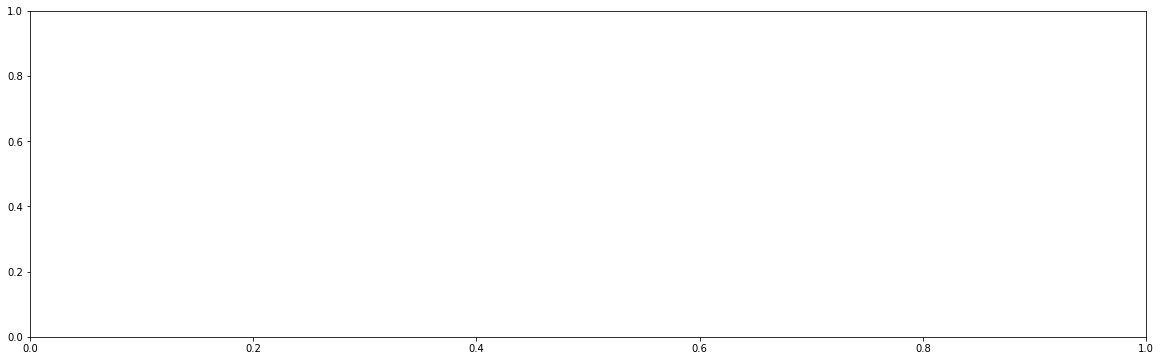

In [5]:
df = pd.read_csv(
    "datas/EURUSD_H1 copy 3.csv", sep="\t", header=0, dtype={"open": float,"close": float,"tickvol": float,"vol": float},
    parse_dates=[[0,1]],
    index_col=[0],
    names=["date","time","open","high","low","close","tickvol","vol","spread"])
t_count = input_width+2**6
t_shift = random.randint(0,2**10)
prices = df['open'][-t_count-t_shift:-1-t_shift]
ds = predictor.dataloader.make_dataset(prices)
di = predictor.dataloader.make_input(prices)
f = predictor.predict(prices)
# do = predictor.dataloader.make_output(di,f)
for i in di:
    print(i)
t = np.arange(len(prices)+predictor.dataloader.total_window_size)
inputs = np.diff(prices)
plt.subplots(nrows=1, ncols=1, figsize=(20,6))
e = predictor.evaluate()
print(e[0])
# r = predictor.predict(prices)
# for i in range(1,r.shape[0]-shift):
#     idx_first = i+predictor.dataloader.input_width
#     idx_last = i+predictor.dataloader.input_width+shift        inputs = Input(shape=(input_width,))

#     plt.plot(t[idx_first:idx_last], r[i:i+shift], marker='x')
#     plt.plot(t[idx_first:idx_last], inputs[idx_first:idx_last], marker='o')
# plt.plot(t[predictor.dataloader.input_width:], np.zeros(len(t)-predictor.dataloader.input_width))

In [2]:
df = pd.read_csv(
            "datas/EURUSD_H1 copy 3.csv",
            sep="\t",
            header=0,
            dtype={
                "open": np.float32,
                "close": np.float32,
                "tickvol": np.float32,
                "vol": np.float32,
            },
            names=["date", "time", "open", "high", "low", "close", "tickvol", "vol"],
        )
std = (np.array(df['open'][1:])-np.array(df['open'][:-1])).std()
mean = (np.array(df['open'][1:])-np.array(df['open'][:-1])).mean()
print(round(std*2,5), round(mean*2,7))


0.00232 -0.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Concatenate

def cross(kernels: list(tf.keras.layers.Layer))->Model:
    k = lambda x: Concatenate()([l(x) for l in kernels])
    return k

i = Input(shape=(8,))
l = [Dense(8), Dense(8)]
model = tf.keras.Model(inputs=i, outputs=cross(l)(i))
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False,to_file="models/test1.png")




TypeError: 'type' object is not iterable

In [24]:
class ClippedCSE(tf.keras.losses.Loss):
    def __init__(
        self,
        value_min=-1.0,
        value_max=1.0,
        count=8,
        reduction=tf.keras.losses.Reduction.AUTO,
        name="clipped_cse",
    ) -> None:
        super().__init__(reduction=reduction, name=name)
        self.value_min = value_min
        self.value_max = value_max
        self.count = count
        self.step = (self.count - 1) / (self.value_max - self.value_min)

    def call(self, y_true, y_pred):
        clipped_y_pred = tf.clip_by_value(y_pred, self.value_min, self.value_max)
        clipped_y_true = tf.clip_by_value(y_true, self.value_min, self.value_max)
        # n_pred = (clipped_y_pred - self.value_min) * self.step
        indices = ((clipped_y_true - value_min) * step).numpy().astype(int).flatten()
        indices = indices.reshape((y_true.shape[0],))
        y_true_batch = tf.zeros_like(y_pred).numpy()
        y_true_batch[np.arange(y_pred.shape[0]), indices] = 1.0
        return tf.losses.cosine_similarity(y_true_batch, clipped_y_pred)

In [60]:
count = 4
value_max = 4
value_min = -4
step = (count - 1) / (value_max - value_min)
y_true = tf.constant([[-4.], [0.], [4.]])
y_pred = tf.constant([[1., 0, 0, 0], [0., 0, 1., 0], [1., 0, 0, 1]])
clipped_y_pred = tf.clip_by_value(y_pred, value_min, value_max)
clipped_y_true = tf.clip_by_value(y_true, value_min, value_max)
indices = ((clipped_y_true - value_min) * step).numpy().astype(int).flatten()

y_true_batch = tf.zeros_like(y_pred).numpy()
y_true_batch[np.arange(y_pred.shape[0]), indices] = 1.0
print(indices)
print(y_true_batch)
print(tf.losses.cosine_similarity(y_true_batch, clipped_y_pred).numpy())

[0 1 3]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
[-1.         -0.         -0.70710677]
